In [1]:
from matplotlib import pyplot as plt
from torch import nn
from tqdm import tqdm
from dataset.FastPatchExtractor import FastPatchDataset, FastPatchExtractor
from operators.gaussian_blur import GaussianBlur
from operators.noise_operator import NoiseOperator
import torch
from patchNR.model import create_NF
from skimage.metrics import structural_similarity as ssim

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
#mean=0
#std = 50
#operator = NoiseOperator(mean, std)
operator = GaussianBlur(kernel_size=5, sigma=3, device=DEVICE)

TypeError: GaussianBlur.__init__() got an unexpected keyword argument 'device'

In [17]:
rec_image = FastPatchDataset('data/material_pt_nr/test.png', 9).images[0]
with torch.no_grad():
    noisy = operator(rec_image)
    noisy = noisy + 5/255*torch.randn(noisy.shape,device=DEVICE)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

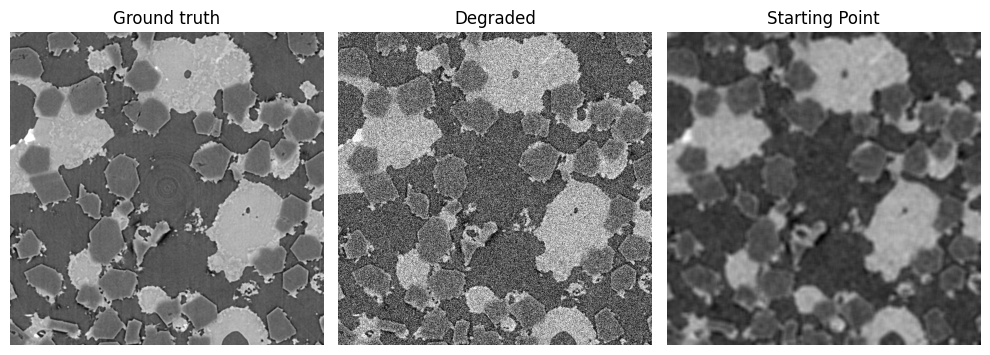


Ground Truth and Degraded SSIM: 0.17292324932234782


In [9]:
blur = GaussianBlur(11, 5)
starting_point = blur(deg_rec_image)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(rec_image.squeeze(), cmap='gray')
axes[0].set_title('Ground truth')
axes[0].axis('off')
axes[1].imshow(deg_rec_image.squeeze(), cmap='gray')
axes[1].set_title('Degraded')
axes[1].axis('off')
axes[2].imshow(starting_point.squeeze(), cmap='gray')
axes[2].set_title(f'Starting Point')
axes[2].axis('off')
plt.tight_layout()
plt.show()
print(f'')
ground_truth = rec_image.squeeze().detach().numpy()
degraded_ground_truth = deg_rec_image.squeeze().detach().numpy()
print(f'Ground Truth and Degraded SSIM: {ssim(ground_truth, degraded_ground_truth, data_range=1)}')

In [10]:
weight = 'patchNR/patchNR_weights/weights_material.pth'

In [11]:
patch_size = 6
num_layers = 5
subnet_nodes = 512
net = create_NF(num_layers, subnet_nodes, dimension=patch_size**2)
weights = torch.load(weight, map_location=DEVICE)
net.load_state_dict(weights['net_state_dict'])

<All keys matched successfully>

In [12]:
from torch.utils.tensorboard import SummaryWriter


def reconstruct(observation, start, lam, patch_size, n_patches_out, model, operator, n_iter_max):
    model.to(DEVICE)
    summaryWriter = SummaryWriter()
    """
    Defines the reconstruction using patchNR as regularizer
    """

    # fixed parameters
    obs = observation.to(DEVICE)
    operator = operator.to(DEVICE)
    center = False
    init = start.to(DEVICE)
    pad_size = 4 #pad the image before extracting patches to avoid boundary effects
    pad = [pad_size]*4

    # create patch extractors
    patch_extractor = FastPatchExtractor(patch_size, pad=False, center=center, device=DEVICE).to(DEVICE)

    # intialize optimizer for image
    fake_img = torch.tensor(init.clone(), dtype=torch.float32, device=DEVICE, requires_grad=True)
    optim_img = torch.optim.Adam([fake_img], lr=0.005)
    bar = tqdm(range(n_iter_max))

    loss_list = []
    # Main loop
    for it in bar:
        optim_img.zero_grad()
        tmp = nn.functional.pad(fake_img, pad, mode='reflect')
        fake_data = patch_extractor.extract(tmp, n_patches_out)
        pred_inv, log_det_inv = model(fake_data,rev=True)
        reg = torch.mean(torch.sum(pred_inv**2,dim=1)/2) - torch.mean(log_det_inv)

        #data fidelity
        data_fid = torch.sum((operator(fake_img) - obs)**2)
        #data_fid = torch.sum((fake_img - obs)**2)

        #loss
        loss = data_fid + lam*reg
        summaryWriter.add_scalar('Data', data_fid, it)
        summaryWriter.add_scalar('Reg', reg, it)
        summaryWriter.add_scalar('Loss', loss, it)
        loss_list.append([data_fid, reg, loss])
        bar.set_description_str('D/R: {data:.2f}  - {reg:.2f} | L: {loss:.2f} '.format(data=data_fid, reg=reg, loss=loss))
        loss.backward()
        optim_img.step()
    return fake_img, loss_list

In [13]:
lam = 0.87
n_pat = 80000
iteration = 300

rec, loss = reconstruct(deg_rec_image, starting_point, lam = lam, patch_size = patch_size, n_patches_out = n_pat,
              model = net, n_iter_max = iteration)

/var/tmp/ipykernel_3804/3458875558.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake_img = torch.tensor(init.clone(), dtype=torch.float32, device=DEVICE, requires_grad=True)
D/R: 688.90  - 760.20 | L: 1350.28 : 100%|██████████| 300/300 [02:42<00:00,  1.84it/s]  


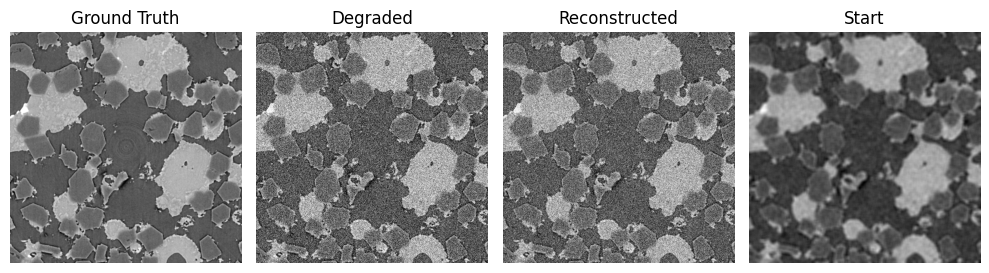

In [14]:
reconstructed = rec.detach().cpu().squeeze()
expected = rec_image.squeeze().cpu()
degraded = deg_rec_image.squeeze().cpu()
# Create a figure with two subplots arranged horizontally
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(expected, cmap='gray')
axes[0].set_title('Ground Truth')
axes[0].axis('off')
axes[1].imshow(degraded, cmap='gray')
axes[1].set_title('Degraded')
axes[1].axis('off')
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title(f'Reconstructed')
axes[2].axis('off')
axes[3].imshow(starting_point.squeeze(), cmap='gray')
axes[3].set_title(f'Start')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [15]:
print(f'Ground Truth and Degraded SSIM: {ssim(ground_truth, reconstructed.numpy(), data_range=1)}')

Ground Truth and Degraded SSIM: 0.21279647405641355


In [61]:
patch_extractor = FastPatchExtractor(50)

In [ ]:
patch_extractor.extract(rec)[3]

NameError: name 'patch_extractor' is not defined

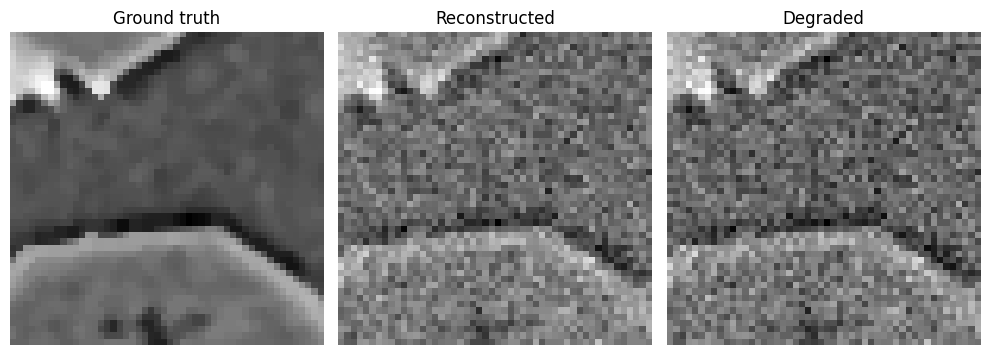

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(ground_truth, cmap='gray')
axes[0].set_title('Ground truth')
axes[0].axis('off')
axes[1].imshow(reconstructed, cmap='gray')
axes[1].set_title('Reconstructed')
axes[1].axis('off')
axes[2].imshow(deg_rec_image, cmap='gray')
axes[2].set_title(f'Degraded')
axes[2].axis('off')
plt.tight_layout()
plt.show()